# Evaluate Performance of Various Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 15, 
      'axes.titlesize': 15,
      'legend.fontsize': 15,
      'xtick.labelsize': 12
     }
#       'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('whitegrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

Functions:
1. Read csv from runs.
2. Plot monthly west and east temperature and comfortable range. (Visualization of violations)
3. Calculate the PUE of various models on various cities. (Energy Performance)
4. Calculate violations percentage of various models on various cities. (Temperature Constraints)

In [3]:
cities = ['sf', 'golden', 'chicago', 'sterling']

In [19]:
ppo_data_frame = {}
for city in cities:
    folder = 'runs/{}_23.5_0.95_1.5_ppo'.format(city)
    episode_index = 30
    file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
    ppo_data_frame[city] = pd.read_csv(file)

In [5]:
baseline_data_frame = {}
for city in cities:
    folder = 'runs/{}_23.5_1.5_pid'.format(city)
    episode_index = 0
    file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
    baseline_data_frame[city] = pd.read_csv(file)

In [7]:
model_based_data_frame = {}
for city in cities:
    folder = 'runs/{}_23.5_1.5_20_5_8192_10_60_model_based'.format(city)
    episode_index = 2
    file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
    model_based_data_frame[city] = pd.read_csv(file)

In [8]:
def calculate_pue(data_frame, start_index=0, num_days=30):
    end_index = start_index + num_days
    two_month = data_frame[start_index*96:end_index*96]
    ite_power = two_month['ite_power']
    hvac_power = two_month['hvac_power']
    total_power = ite_power + hvac_power
    pue = np.sum(total_power) / np.sum(ite_power)
    return pue

In [9]:
def violation_rate(data_frame, temperature_center=23.5, temperature_tolerance=1.5,
                  start_index=0, num_days=30):
    end_index = start_index + num_days
    two_month = data_frame[start_index*96:end_index*96]
    west_temperature = two_month['west_temperature'].values
    east_temperature = two_month['east_temperature'].values
    upper_bound = temperature_center + temperature_tolerance
    lower_bound = temperature_center - temperature_tolerance
    west_temp_violation = np.logical_or(west_temperature > upper_bound, 
                                        west_temperature < lower_bound)
    east_temp_violations = np.logical_or(east_temperature > upper_bound,
                                        east_temperature < lower_bound)
    total_violations = np.logical_or(west_temp_violation, east_temp_violations)
    violation_rate = np.sum(total_violations) / total_violations.shape[0]
    return violation_rate

In [94]:
def plot_temperature(data_frame, city, temperature_center=23.5, temperature_tolerance=1.5, 
                     start_index=0, num_days=30):
    end_index = start_index + num_days
    two_month = data_frame[start_index*96:end_index*96]
    x = np.linspace(0, num_days, num_days * 96)
    west_temperature = two_month['west_temperature'].values
    east_temperature = two_month['east_temperature'].values
    plt.figure(figsize=(15, 8))
    plt.plot(x, west_temperature, label='west_temperature')
    plt.plot(x, east_temperature, label='east_temperature')
    plt.hlines([temperature_center + temperature_tolerance, 
                temperature_center - temperature_tolerance],
              x[0], x[-1], colors='r', linestyles='dashed', label='comfortable zone')
    plt.xlabel('Day Index')
    plt.ylabel('Temperature ($^\circ$C)')
    plt.title('City = {}'.format(city))
    plt.legend()

In [73]:
def plot_bar(data, x_label, y_label, x_ticks, width=0.15, figsize=(15, 5)):
    """
    data: a dictionary map from 4 cities to data
    """
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(data['sf']))
    ax.bar(ind - width/2 * 3, data['sf'], width, label='sf')
    ax.bar(ind - width/2, data['golden'], width, label='golden')
    ax.bar(ind + width/2, data['chicago'], width, label='chicago')
    ax.bar(ind + width/2 * 3, data['sterling'], width, label='sterling')
    ax.set_ylabel(y_label)
    ax.set_xticks(ind)
    ax.set_xlabel(x_label)
    ax.set_xticklabels(x_ticks)
    ax.legend()

### Evaluate training epoches

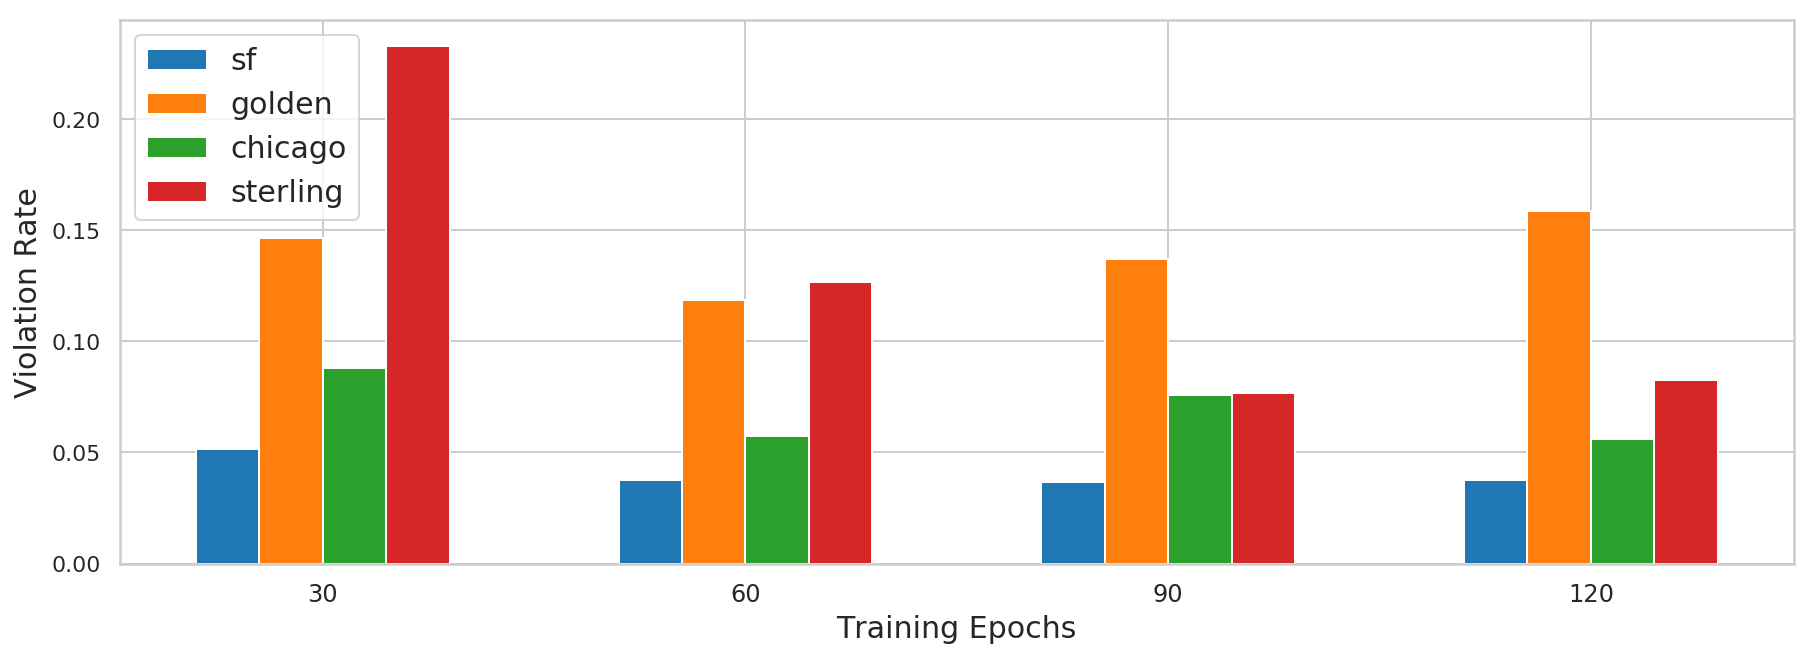

In [76]:
training_epochs = [30, 60, 90, 120]
data = {}
for city in cities:
    data[city] = []
    for start_index in [30, 60, 90, 120]:
        data[city].append(violation_rate(ppo_data_frame[city], start_index=start_index))

plot_bar(data, 'Training Epochs', 'Violation Rate', training_epochs, width=0.15,
        figsize=(15, 5))

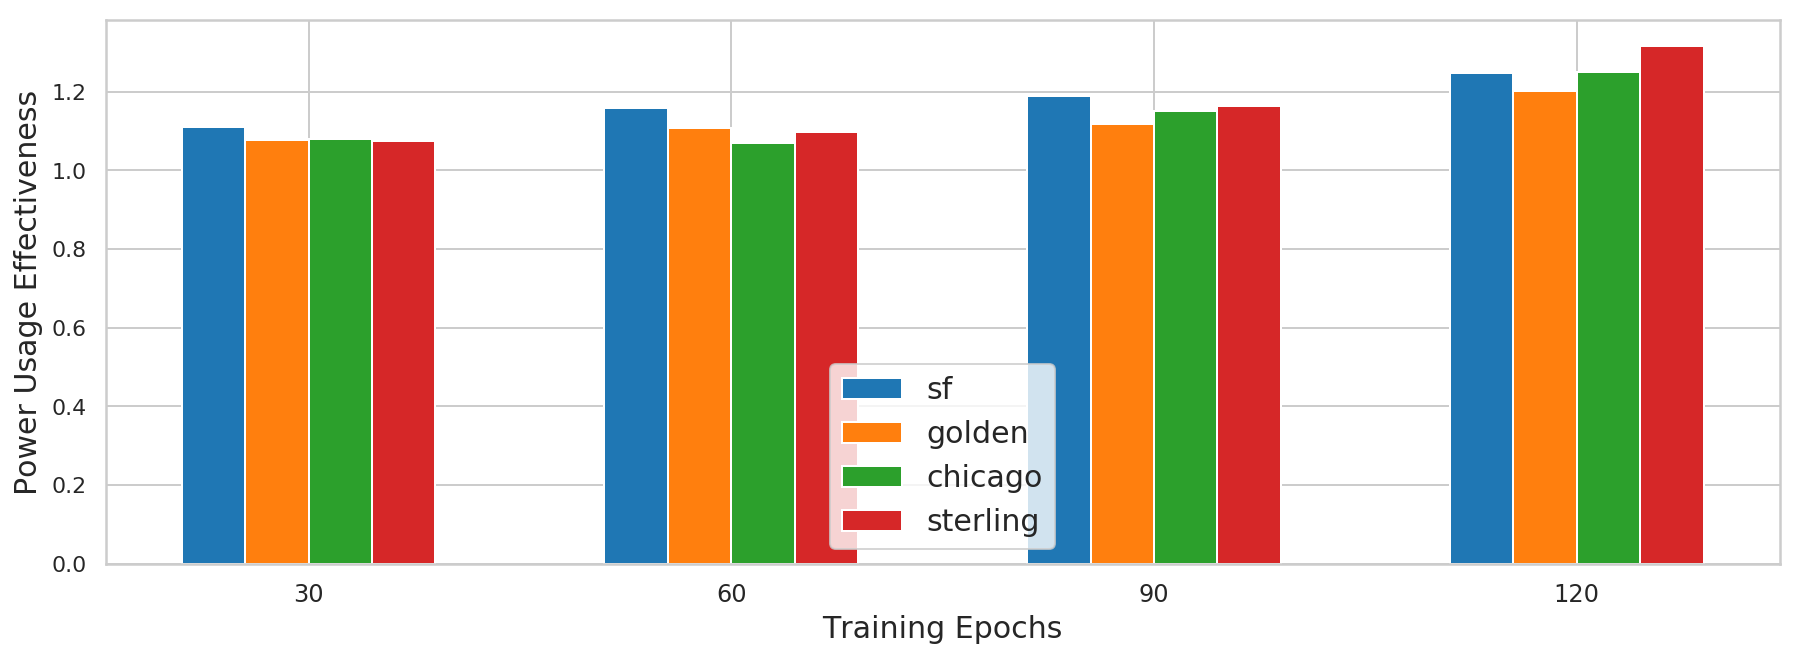

In [77]:
training_epochs = [30, 60, 90, 120]
data = {}
for city in cities:
    data[city] = []
    for start_index in [30, 60, 90, 120]:
        data[city].append(calculate_pue(ppo_data_frame[city], start_index=start_index))

plot_bar(data, 'Training Epochs', 'Power Usage Effectiveness', training_epochs, width=0.15,
        figsize=(15, 5))

### Evaluate MPC horizon

In [78]:
ppo_data_frame = {}
for city in cities:
    folder = 'runs/{}_23.5_0.95_1.5_ppo'.format(city)
    episode_index = 20
    file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
    ppo_data_frame[city] = pd.read_csv(file)

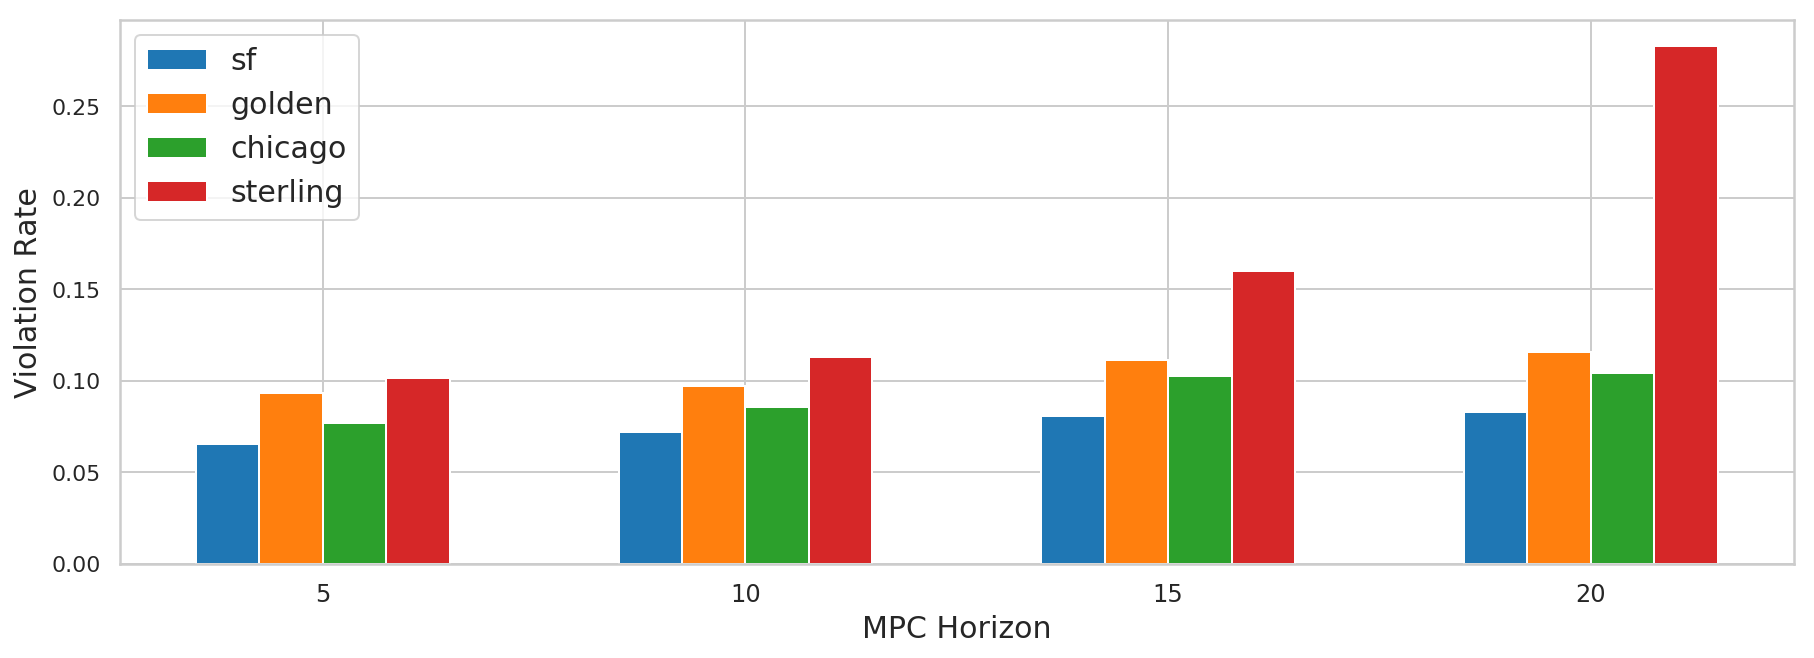

In [79]:
mpc_horizon = [5, 10, 15, 20]
data = {}
for city in cities:
    data[city] = []
    for start_index in [30, 60, 90, 120]:
        data[city].append(violation_rate(ppo_data_frame[city], start_index=start_index))
    data[city] = np.sort(data[city])
plot_bar(data, 'MPC Horizon', 'Violation Rate', mpc_horizon, width=0.15)

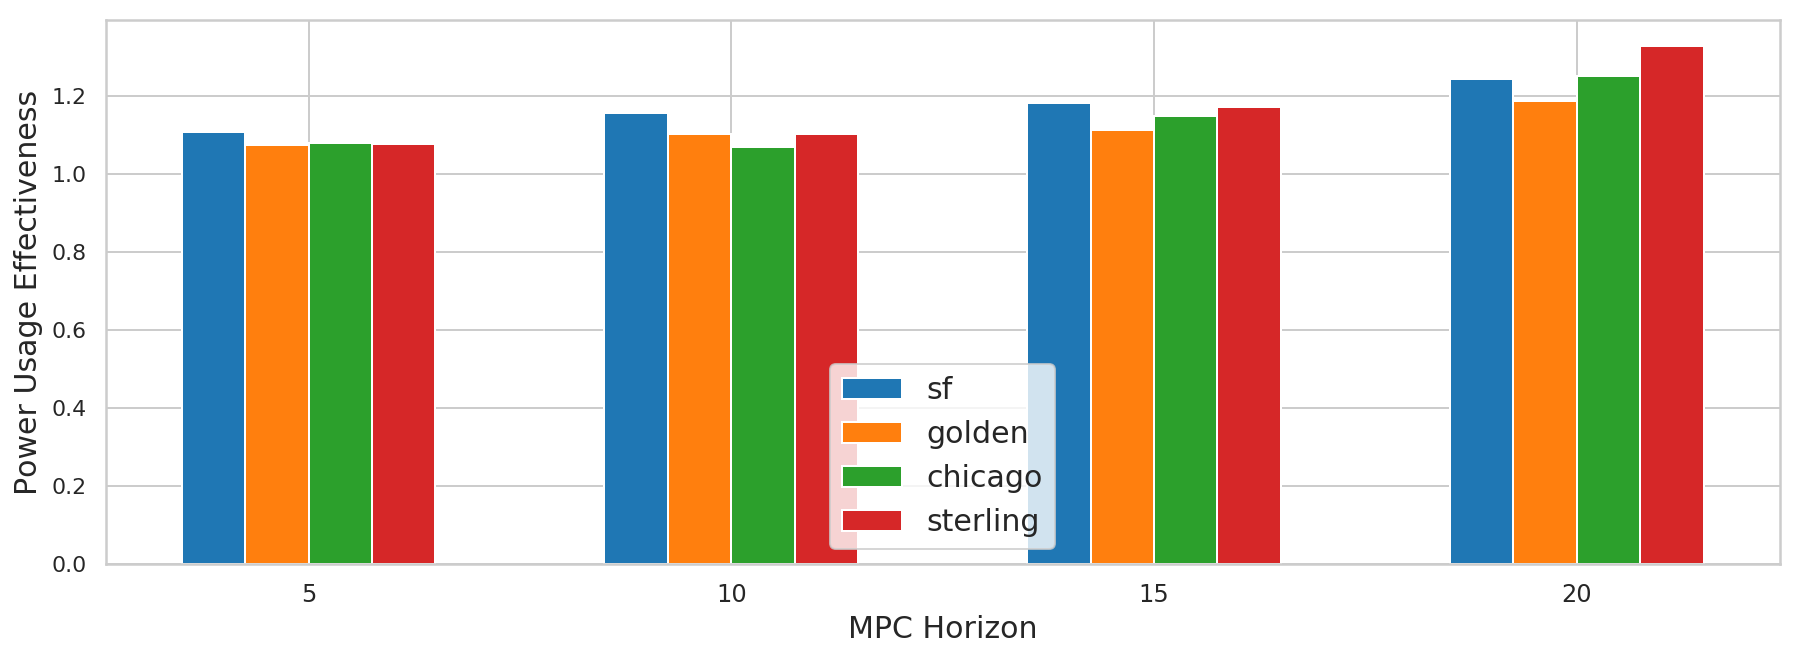

In [80]:
mpc_horizon = [5, 10, 15, 20]
data = {}
for city in cities:
    data[city] = []
    for start_index in [30, 60, 90, 120]:
        data[city].append(calculate_pue(ppo_data_frame[city], start_index=start_index))
plot_bar(data, 'MPC Horizon', 'Power Usage Effectiveness', mpc_horizon, width=0.15)

### Data Aggregation Frequency

In [81]:
ppo_data_frame = {}
for city in cities:
    folder = 'runs/{}_23.5_0.95_1.5_ppo'.format(city)
    episode_index = 33
    file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
    ppo_data_frame[city] = pd.read_csv(file)
    
folder = 'runs/{}_23.5_0.95_1.5_ppo'.format('chicago')
episode_index = 28
file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
ppo_data_frame['chicago'] = pd.read_csv(file)

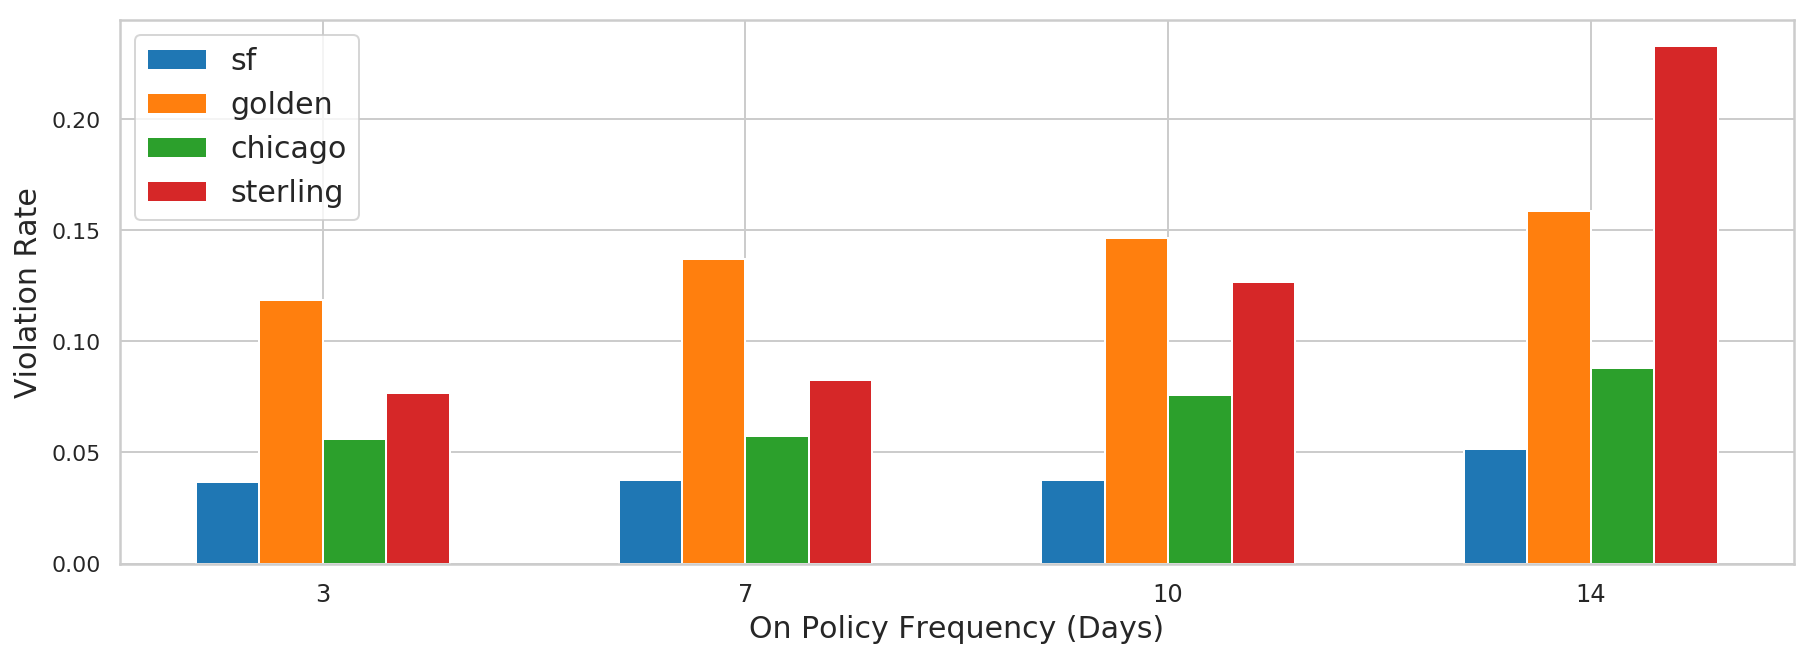

In [82]:
data_aggregation_frequency = [3, 7, 10, 14]
data = {}
for city in cities:
    data[city] = []
    for start_index in [30, 60, 90, 120]:
        data[city].append(violation_rate(ppo_data_frame[city], start_index=start_index))
    data[city] = np.sort(data[city])
plot_bar(data, 'On Policy Frequency (Days)', 'Violation Rate', data_aggregation_frequency, 
         width=0.15)

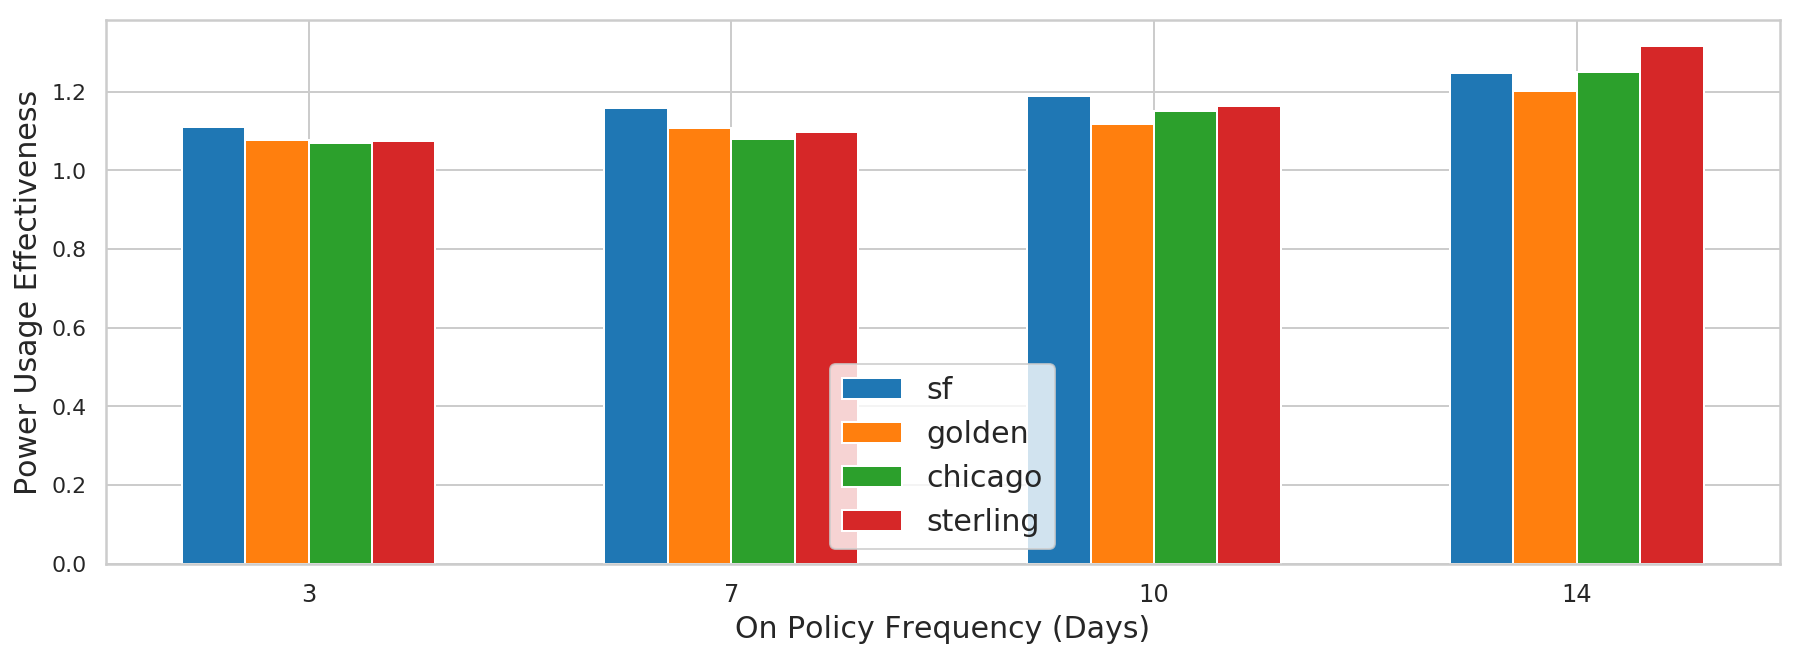

In [83]:
data_aggregation_frequency = [3, 7, 10, 14]
data = {}
for city in cities:
    data[city] = []
    for start_index in [30, 60, 90, 120]:
        data[city].append(calculate_pue(ppo_data_frame[city], start_index=start_index))
    data[city] = np.sort(data[city])
plot_bar(data, 'On Policy Frequency (Days)', 'Power Usage Effectiveness', 
         data_aggregation_frequency, width=0.15)

### Compare MPC vs. Imitation Learning

In [84]:
ppo_data_frame = {}
for city in cities:
    folder = 'runs/{}_23.5_0.95_1.5_ppo'.format(city)
    episode_index = 34
    file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
    ppo_data_frame[city] = pd.read_csv(file)
    
folder = 'runs/{}_23.5_0.95_1.5_ppo'.format('chicago')
episode_index = 27
file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
ppo_data_frame['chicago'] = pd.read_csv(file)

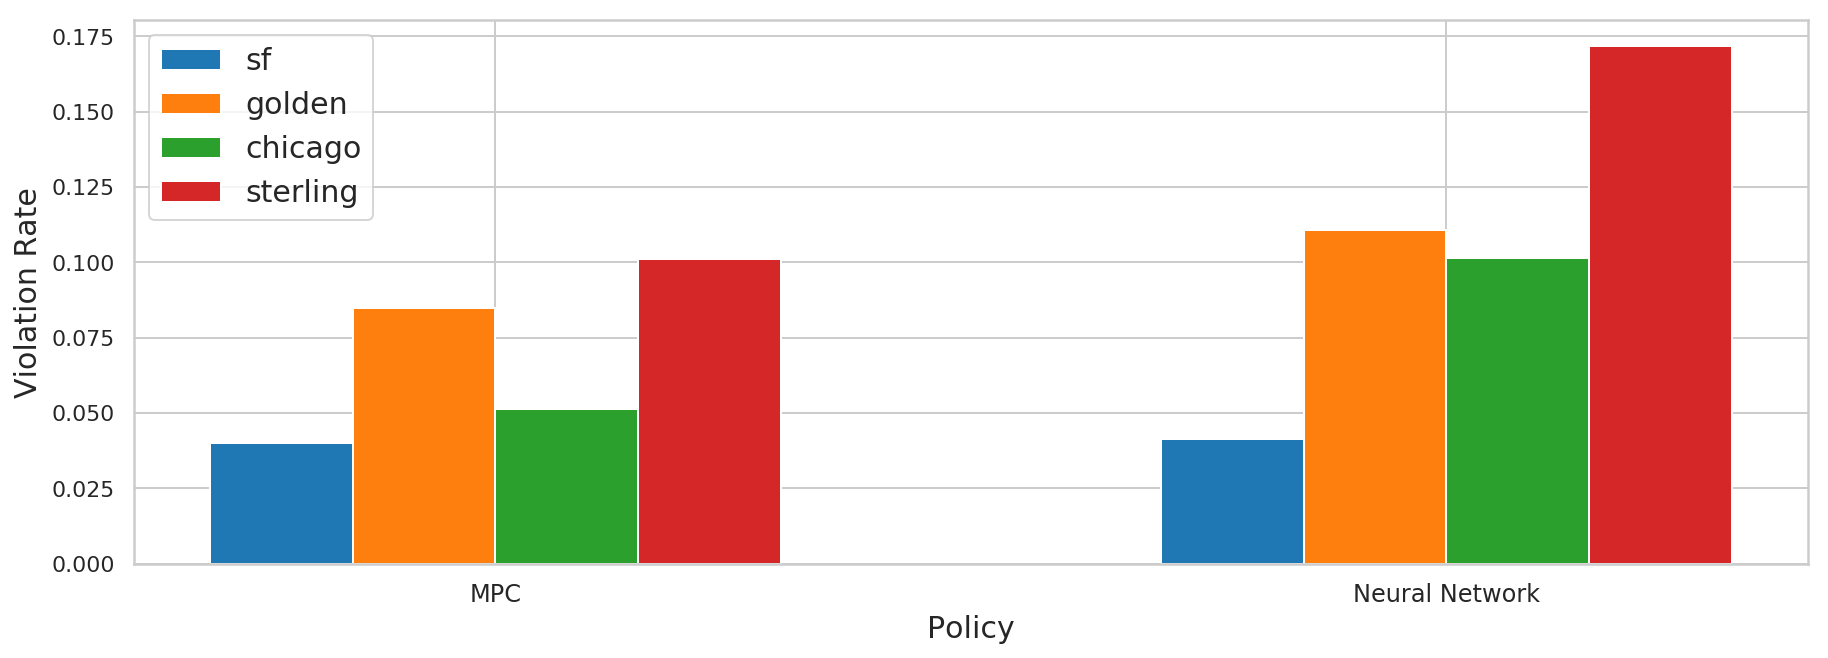

In [85]:
policy = ['MPC', 'Neural Network']
data = {}
for city in cities:
    data[city] = []
    for start_index in [30, 60]:
        data[city].append(violation_rate(ppo_data_frame[city], start_index=start_index))
    data[city] = np.sort(data[city])
plot_bar(data, 'Policy', 'Violation Rate', policy, 
         width=0.15)

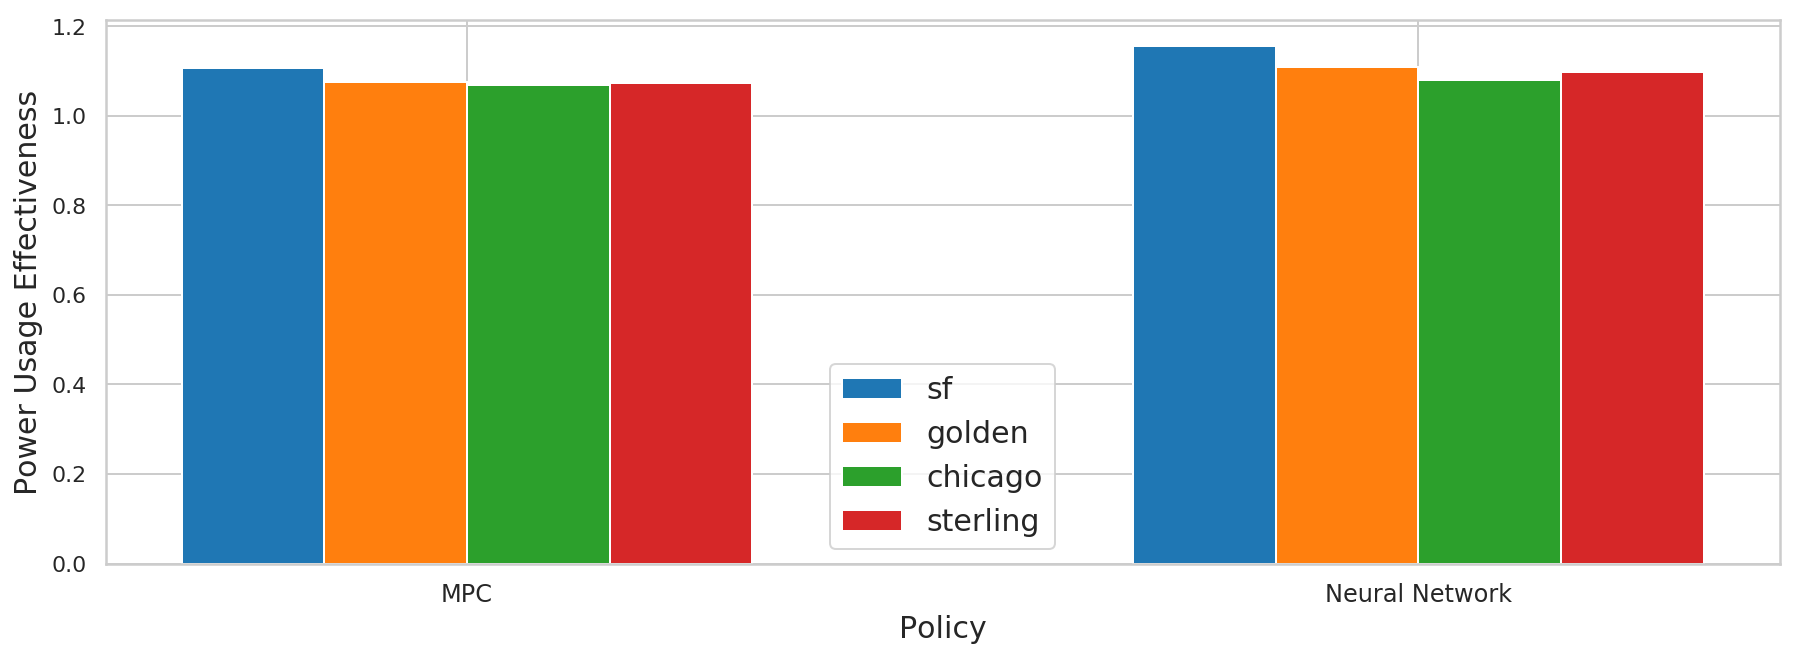

In [87]:
policy = ['MPC', 'Neural Network']
data = {}
for city in cities:
    data[city] = []
    for start_index in [30, 60]:
        data[city].append(calculate_pue(ppo_data_frame[city], start_index=start_index))
    data[city] = np.sort(data[city])
plot_bar(data, 'Policy', 'Power Usage Effectiveness', policy, 
         width=0.15)

### Three figures show baseline, PPO and Model-based on one month HVAC control

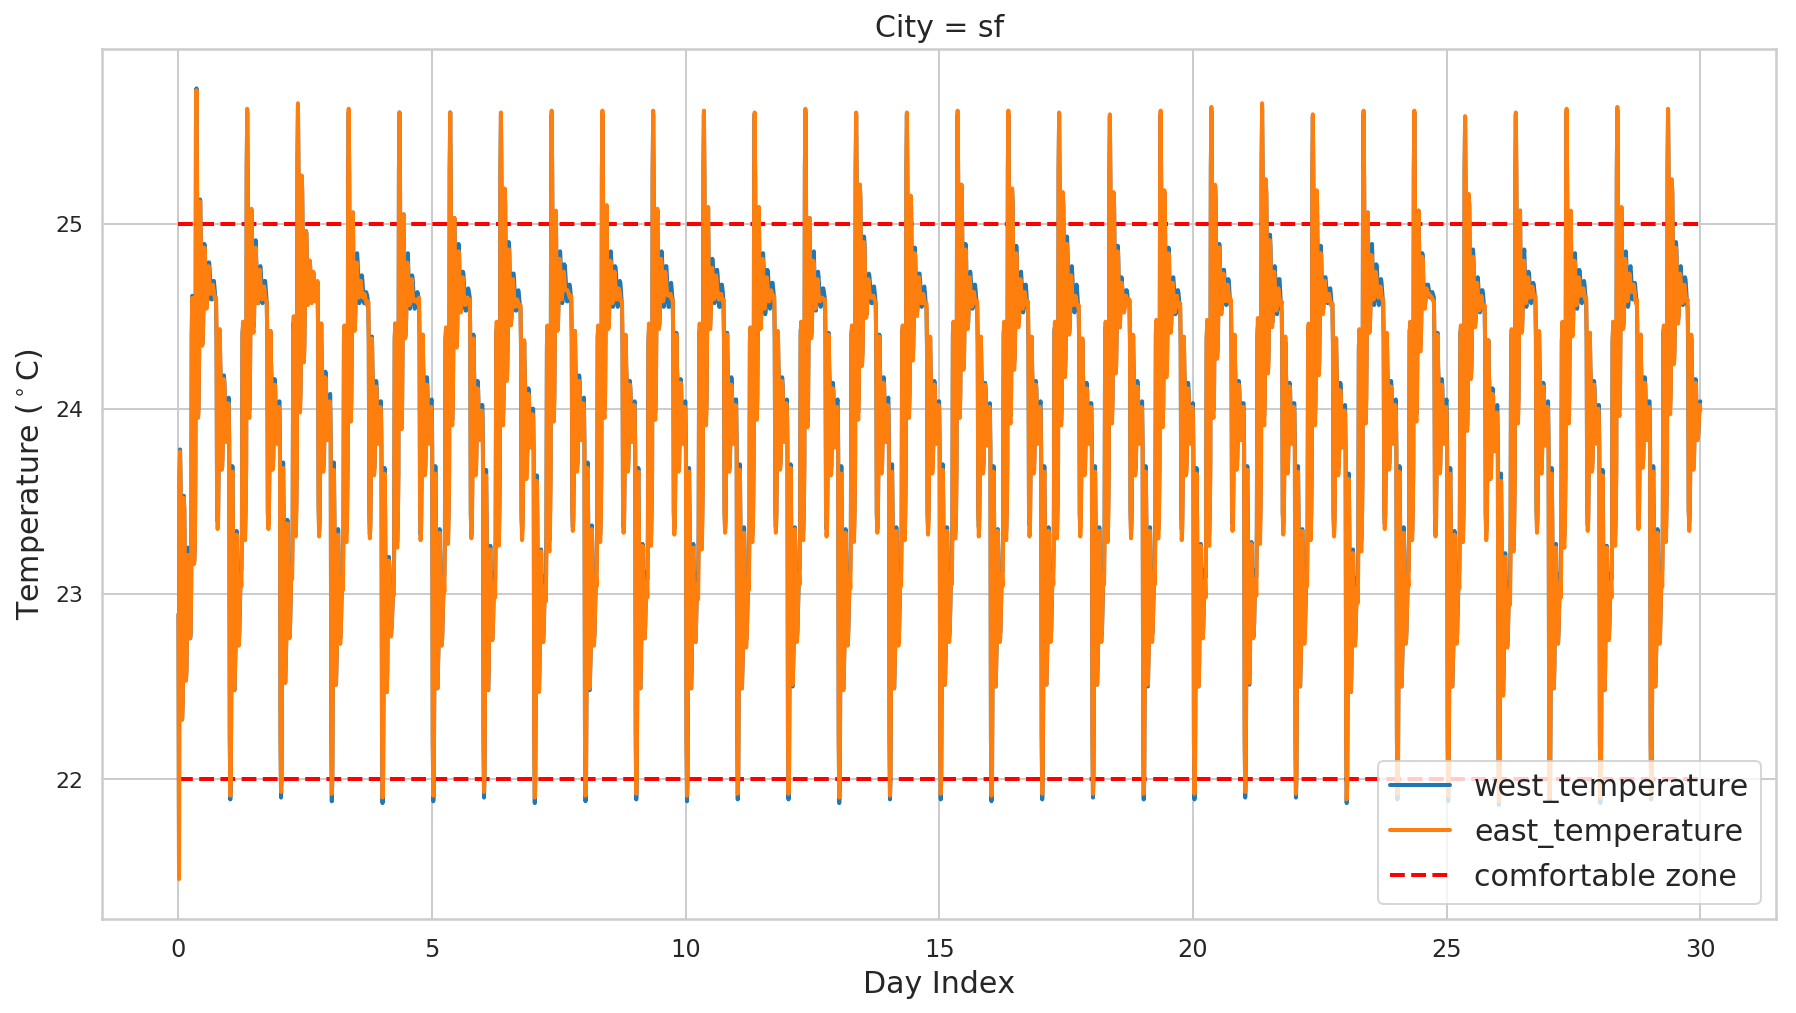

In [102]:
plot_temperature(baseline_data_frame['sf'], city='sf', start_index=0)

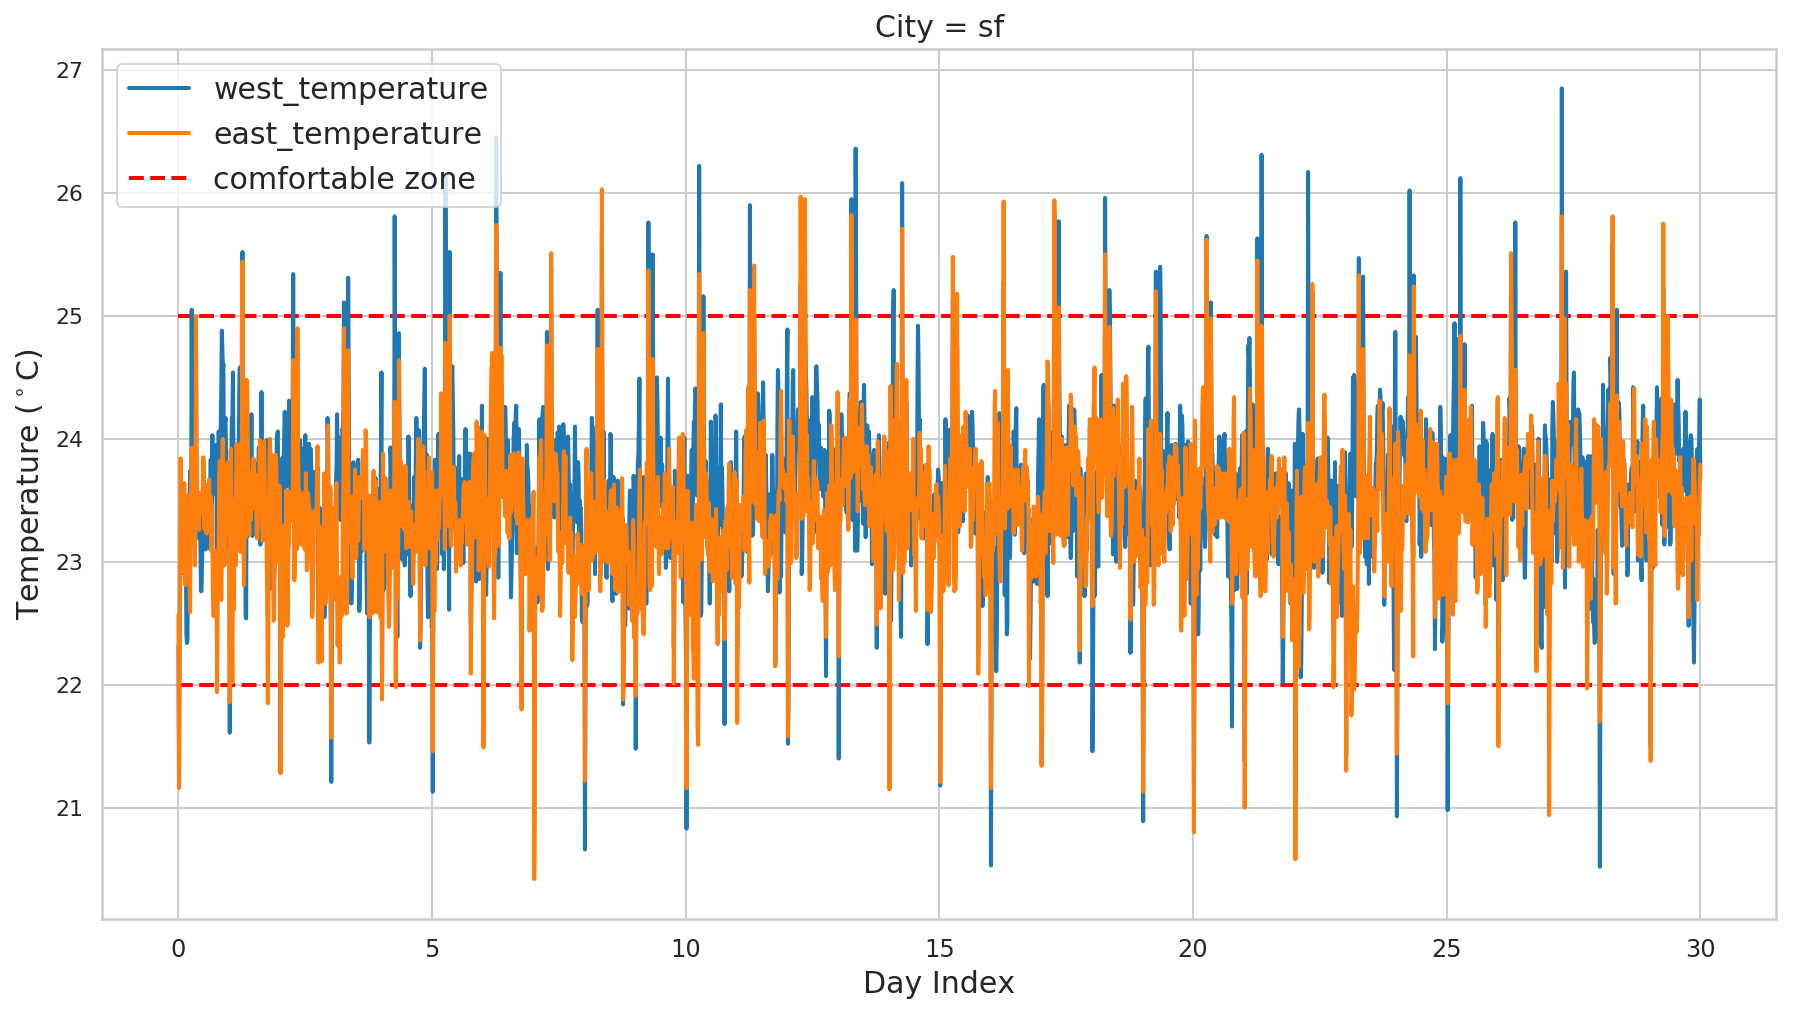

In [95]:
plot_temperature(ppo_data_frame['sf'], city='sf', start_index=60)

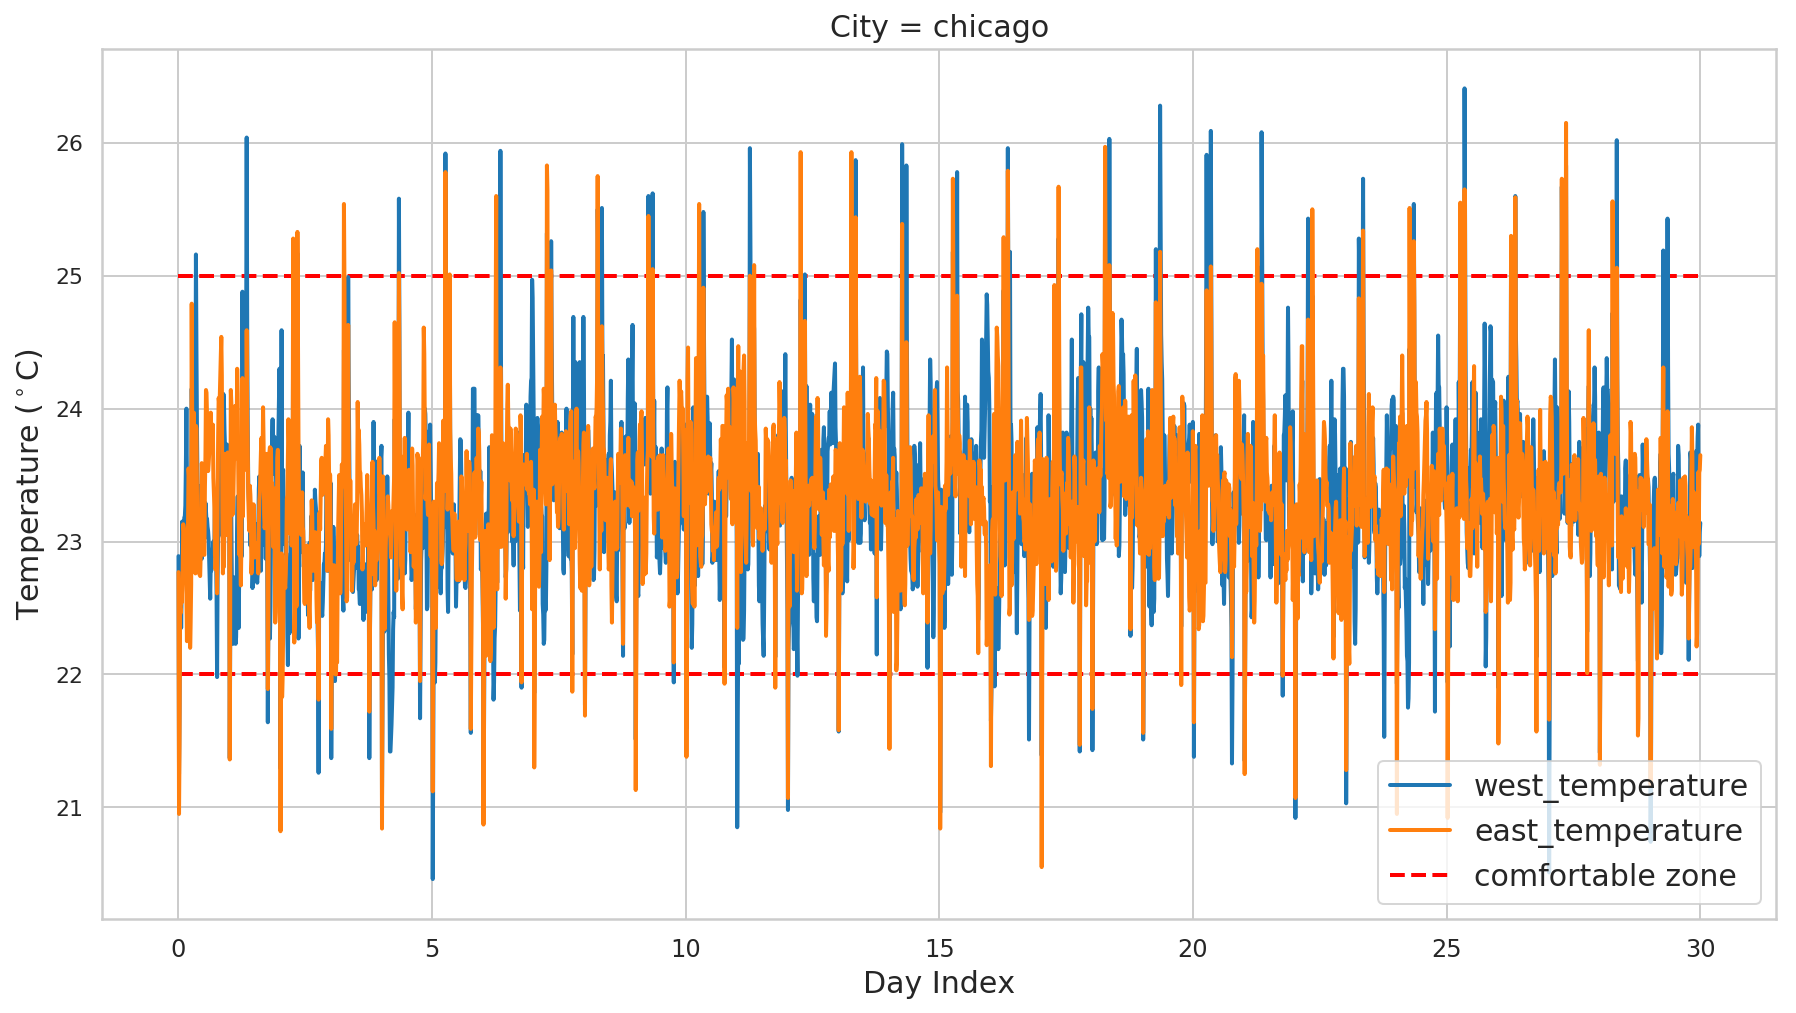

In [96]:
plot_temperature(ppo_data_frame['chicago'], city='chicago', start_index=60)

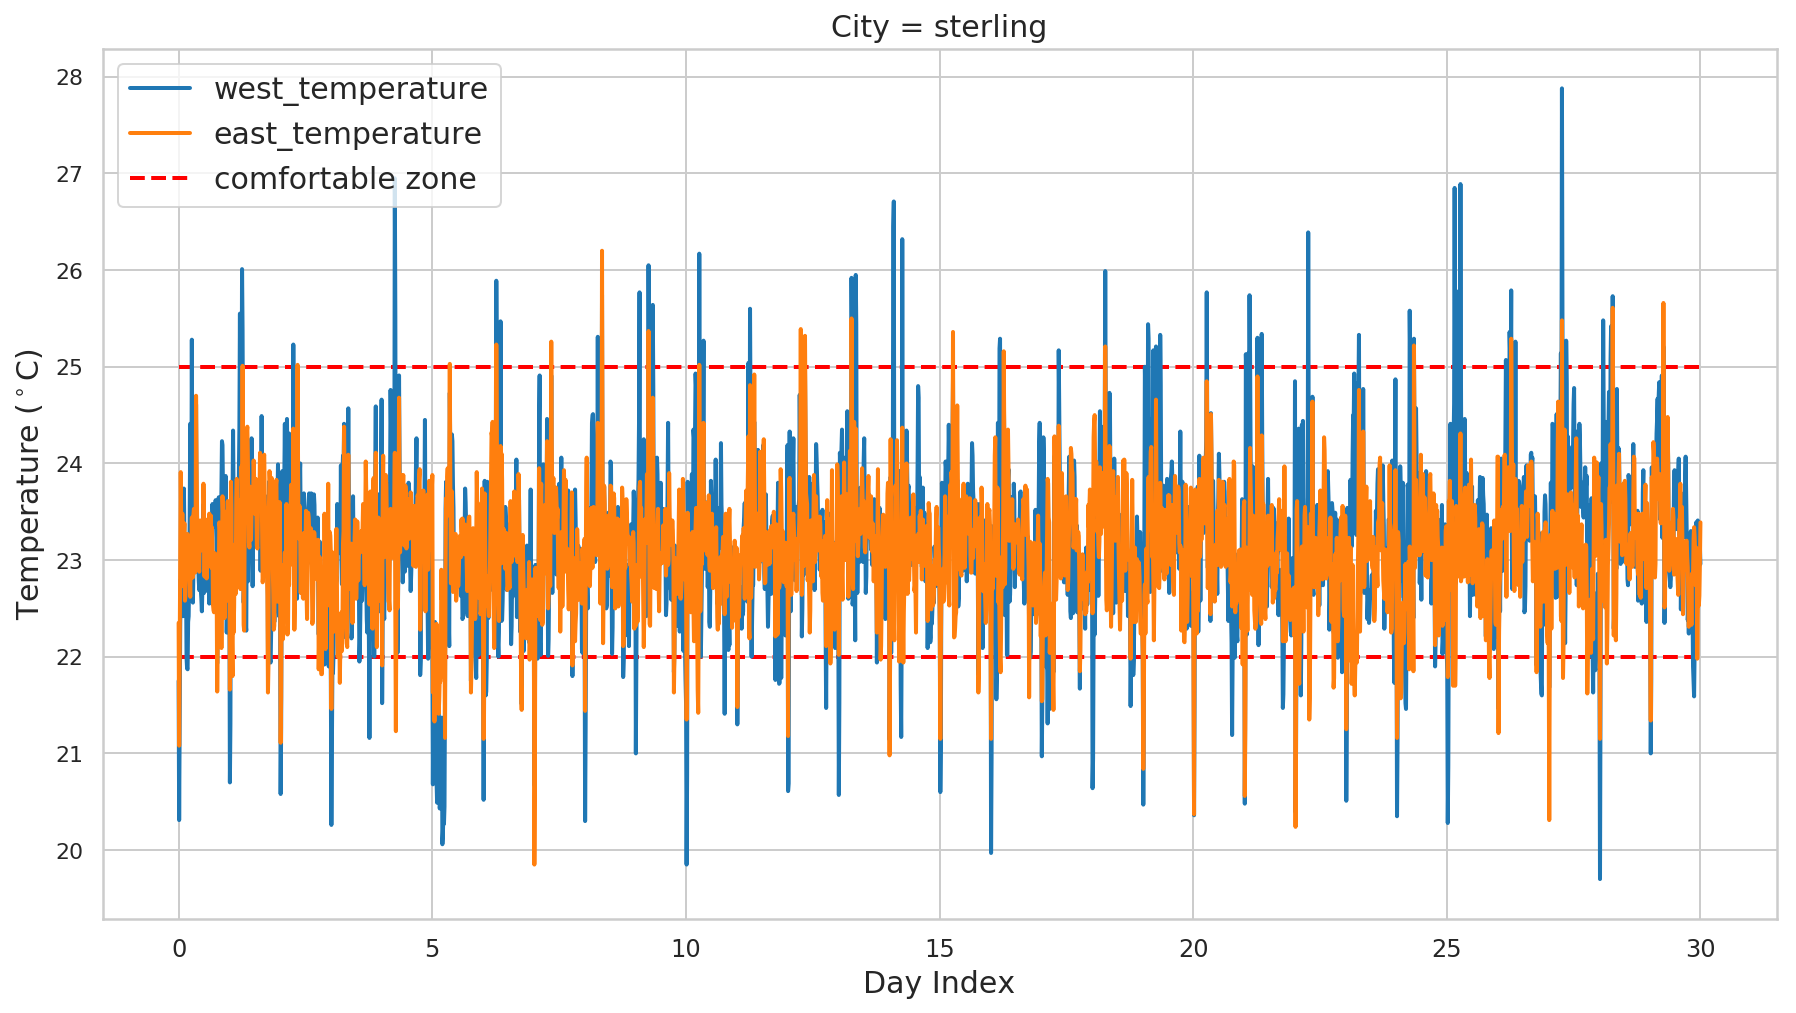

In [97]:
plot_temperature(ppo_data_frame['sterling'], city='sterling', start_index=60)

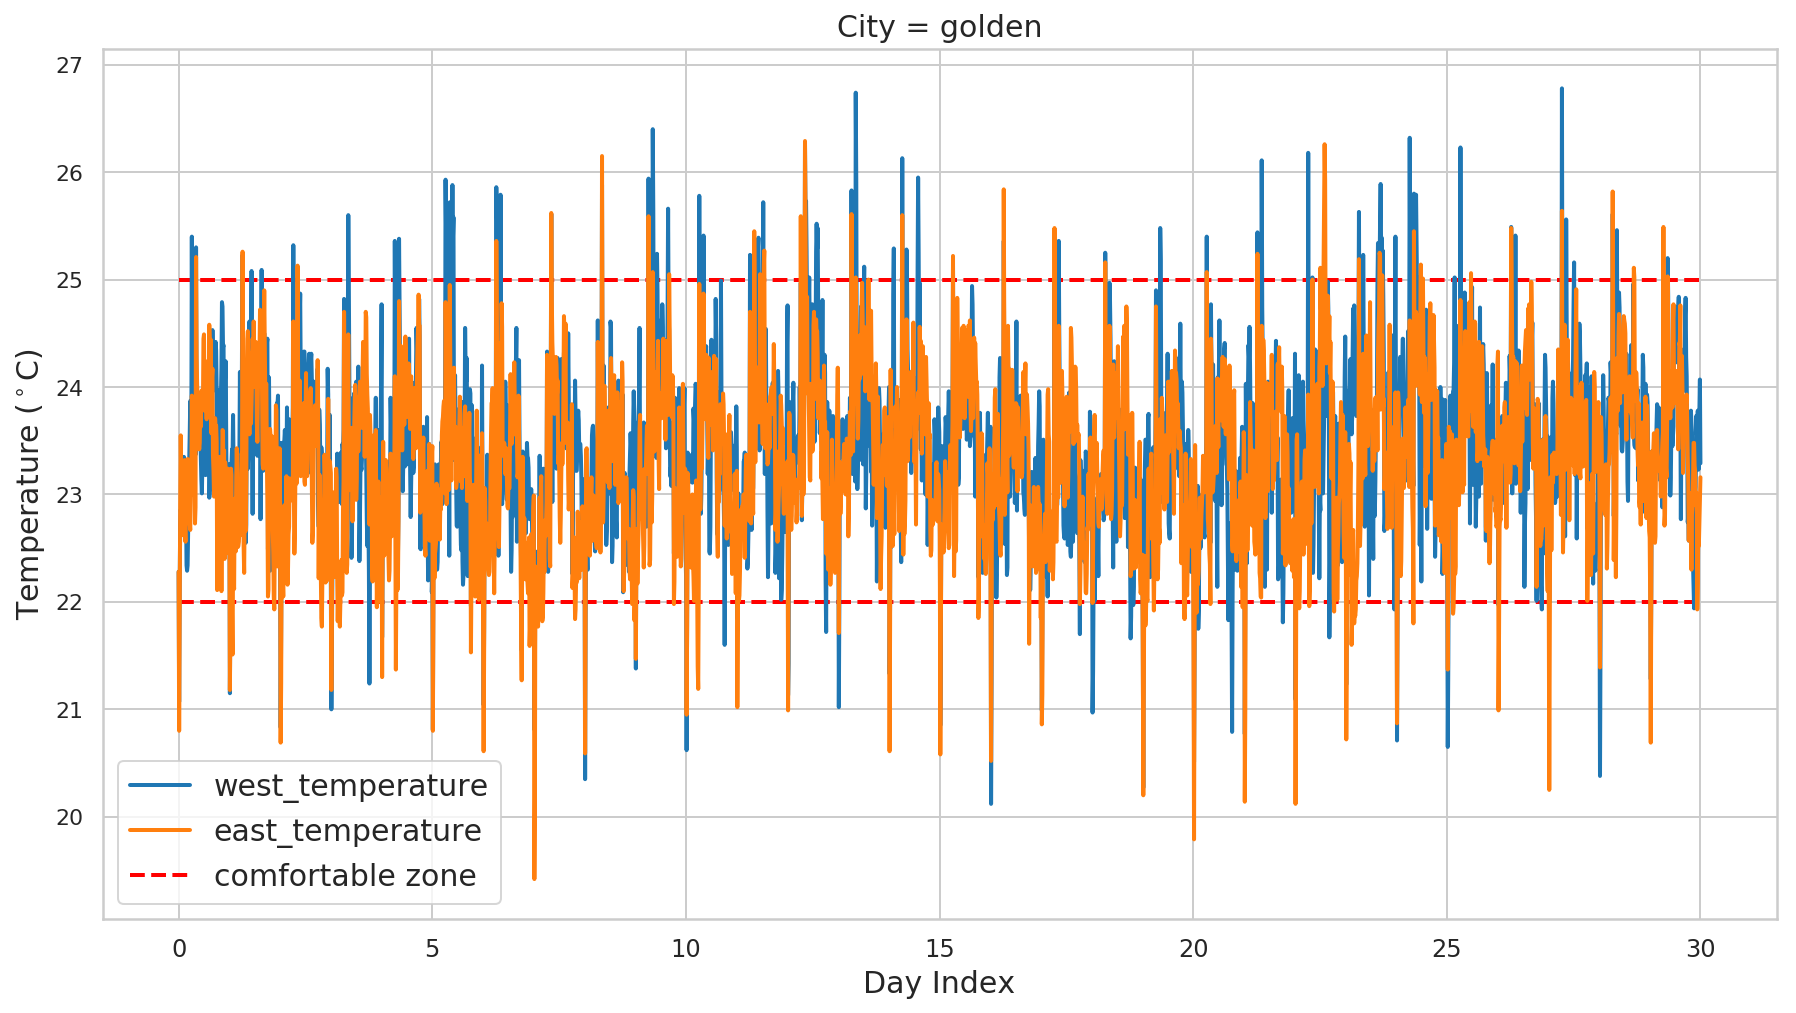

In [98]:
plot_temperature(ppo_data_frame['golden'], city='golden', start_index=60)

### Baseline vs. PPO vs. Model-based on violations and PUE

In [165]:
ppo_data_frame = {}
    
folder = 'runs/{}_23.5_0.95_1.5_ppo'.format('chicago')
episode_index = 26
file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
ppo_data_frame['chicago'] = pd.read_csv(file)

folder = 'runs/{}_23.5_0.95_1.5_ppo'.format('golden')
episode_index = 23
file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
ppo_data_frame['golden'] = pd.read_csv(file)

folder = 'runs/{}_23.5_0.95_1.5_ppo'.format('sterling')
episode_index = 24
file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
ppo_data_frame['sterling'] = pd.read_csv(file)

folder = 'runs/{}_23.5_0.95_1.5_ppo'.format('sf')
episode_index = 27
file = os.path.join(folder, 'episode-{}.csv'.format(episode_index))
ppo_data_frame['sf'] = pd.read_csv(file)

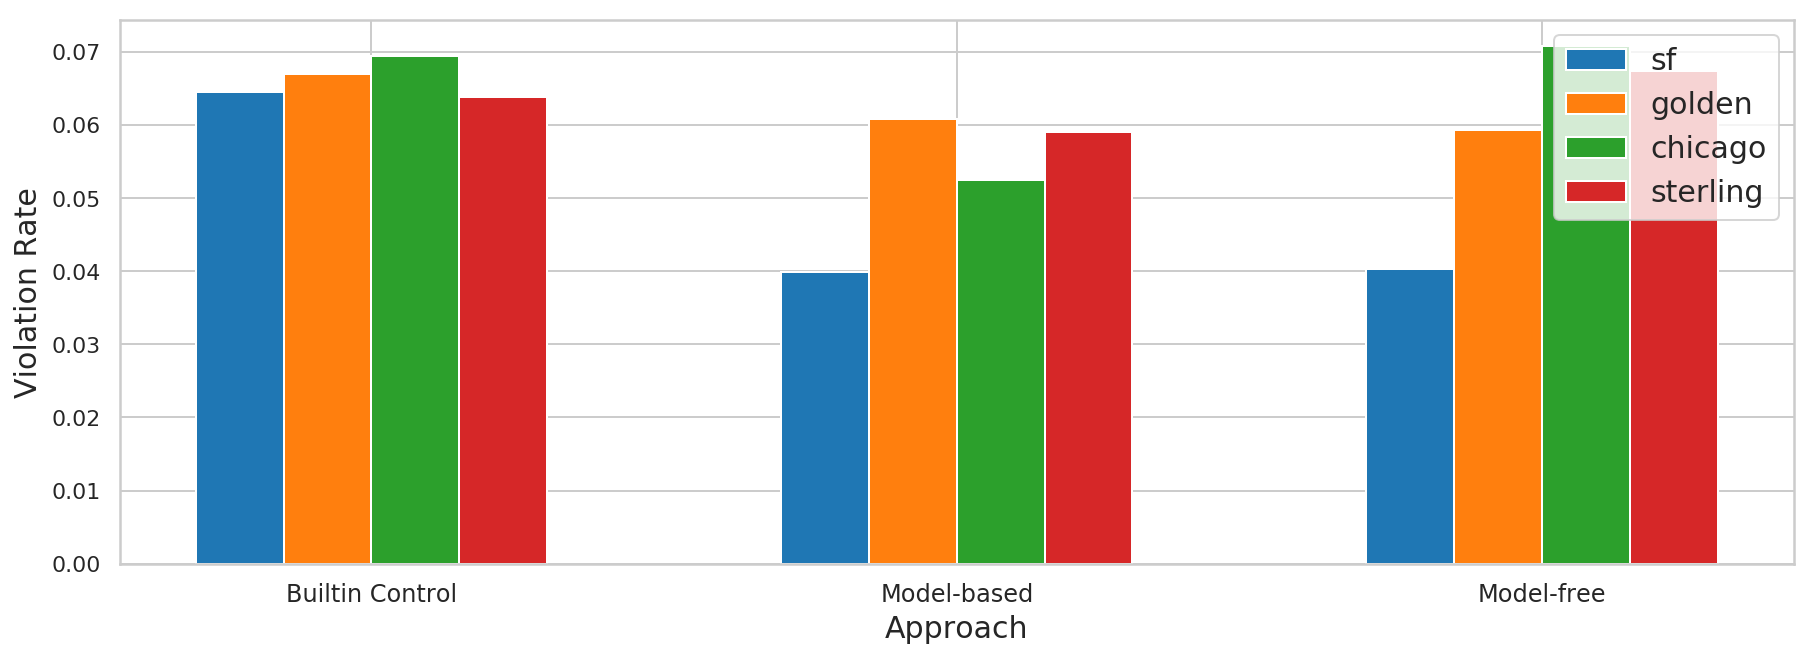

In [166]:
policy = ['Builtin Control', 'Model-based', 'Model-free']
data = {}
for city in cities:
    data[city] = []
    start_index = 60
    data[city].append(violation_rate(baseline_data_frame[city], start_index=start_index))
    for start_index in [60, 90]:
        data[city].append(violation_rate(ppo_data_frame[city], start_index=start_index))
plot_bar(data, 'Approach', 'Violation Rate', policy, 
         width=0.15)

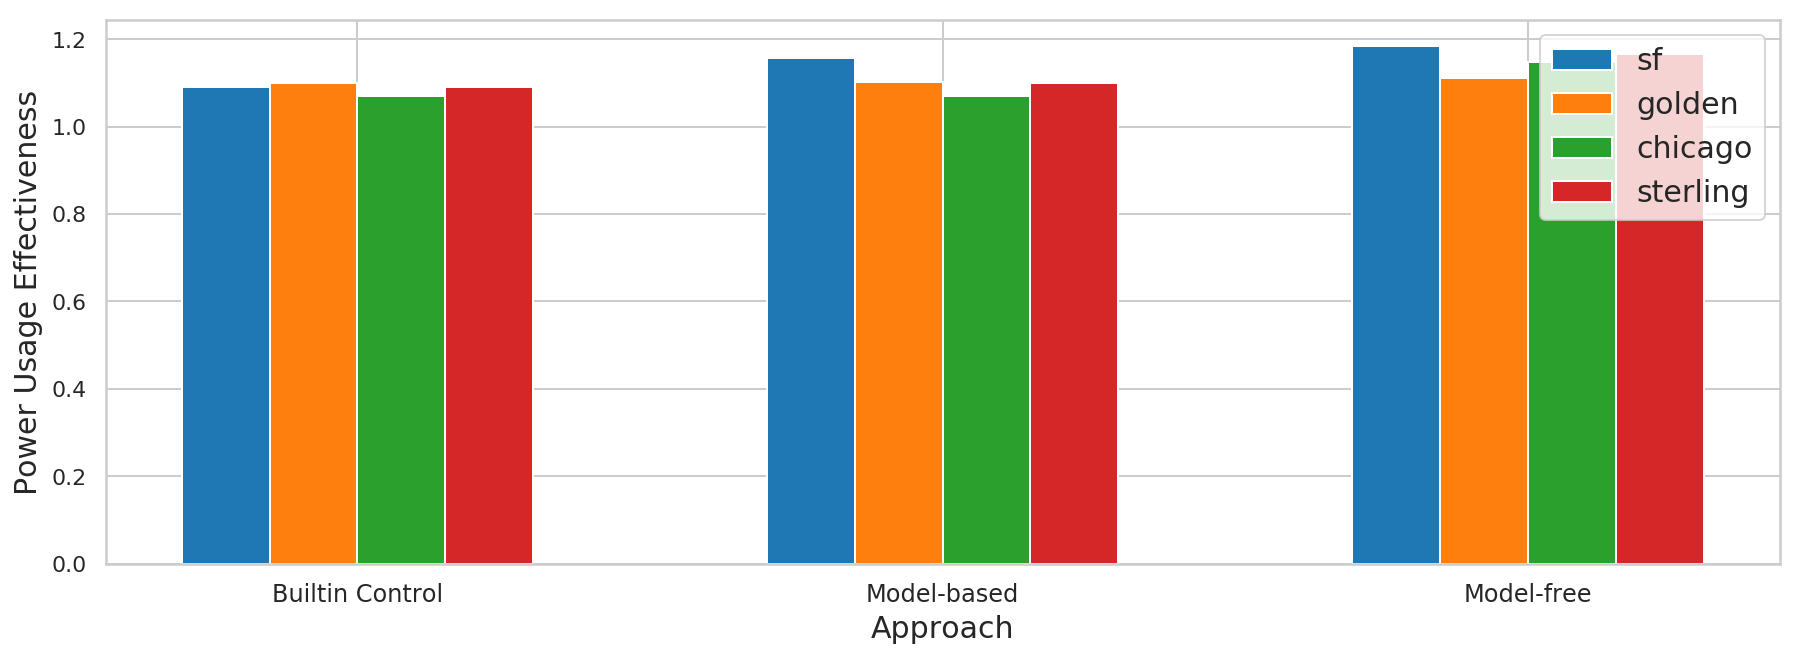

In [167]:
policy = ['Builtin Control', 'Model-based', 'Model-free']
data = {}
for city in cities:
    data[city] = []
    data[city].append(calculate_pue(baseline_data_frame[city], start_index=60))
    for start_index in [90, 60]:
        data[city].append(calculate_pue(ppo_data_frame[city], start_index=start_index))
    data[city] = np.sort(data[city])
plot_bar(data, 'Approach', 'Power Usage Effectiveness', policy, 
         width=0.15)

### Performance vs Training Iterations

In [155]:
model_based_train_stats = pd.read_csv('data/model_based.csv')
ppo_train_stats = pd.read_csv('data/ppo.csv')

Text(0, 0.5, 'Reward')

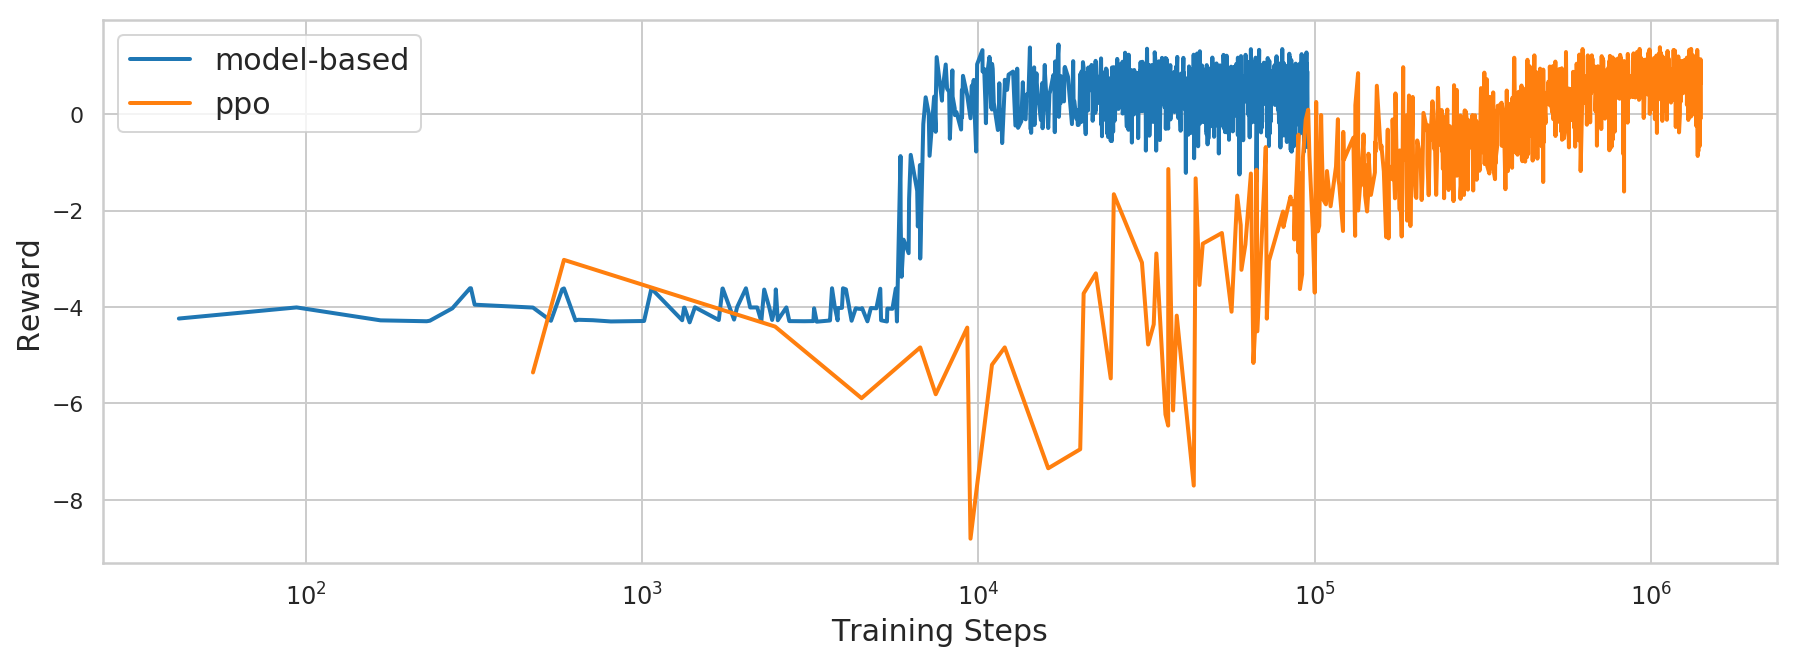

In [161]:
plt.figure(figsize=(15, 5))
plt.semilogx(model_based_train_stats['Step'], (model_based_train_stats['Value'] + 1.5) / 2., 
             label='Our model-based approach')
plt.semilogx(ppo_train_stats['Step'], ppo_train_stats['Value'],
            label='ppo baseline')
plt.legend()
plt.xlabel('Training Steps')
plt.ylabel('Reward')